# Random Forest classifier

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-v0_8-colorblind')
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from src.utils.ds_formatter import format_all
from src.dataset import *
OLD_F_METADATA = "./data/HT_Sensor_metadata.dat"
F_METADATA = "./data/HT_Sensor_metadata_new.dat"
OLD_F_DATASET = "./data/HT_Sensor_dataset.dat"
F_DATASET = "./data/HT_Sensor_dataset_new.dat"

FEATURES = [
  'R1', 'R1_mean', 'R1_dev',
  'R2', 'R2_mean', 'R2_dev',
  'R3', 'R3_mean', 'R3_dev',
  'R4', 'R4_mean', 'R4_dev',
  'R5', 'R5_mean', 'R5_dev',
  'R6', 'R6_mean', 'R6_dev',
  'R7', 'R7_mean', 'R7_dev',
  'R8', 'R8_mean', 'R8_dev',
#   'Temp.', 'Temp._mean', 'Temp._dev',
#   'Humidity', 'Humidity_mean', 'Humidity_dev',
]


In [37]:
df = get_dataset(build_dataset=False)
df.shape

(367259, 31)

In [38]:
X=df[FEATURES]
y=df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f'{X_train.shape} {y_train.shape} {X_test.shape} {y_test.shape}')

(257081, 24) (257081,) (110178, 24) (110178,)


In [39]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=10, bootstrap=True, verbose=1)

In [40]:
clf.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.5s finished


RandomForestClassifier(n_estimators=10, verbose=1)

In [41]:
y_pred=clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [46]:
def print_metrics(y_test, y_pred):
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
    print("F1-score:",metrics.f1_score(y_test, y_pred, average='weighted'))
    plt.rcParams['figure.dpi'] = 70
    cm = metrics.confusion_matrix(y_test, y_pred)
    cmdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    cmdisp.plot()
    plt.show()

Accuracy: 0.9994191217847483
Precision: 0.9994191455702796
F1-score: 0.9994191204390712


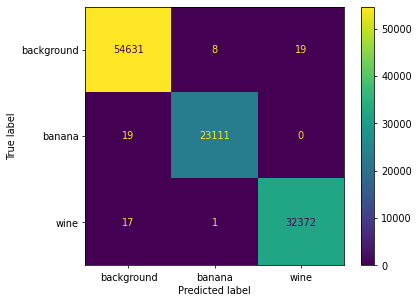

In [47]:
print_metrics(y_test, y_pred)

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=FEATURES).sort_values(ascending=False)
import seaborn as sns
fig, ax = plt.subplots(figsize=(24, 25))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, ax=ax)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Ahora vamos a probar con K-Fold Cross-Validation:

In [15]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

FOLD nº0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 0.9995098840058814
Precision:	 0.9995099922964524
Recall:		 0.9995098840058814
F1-score:	 0.9995098867524874


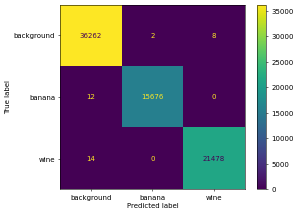

FOLD nº1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 0.9995915700049012
Precision:	 0.9995915687763587
Recall:		 0.9995915700049012
F1-score:	 0.9995915669055855


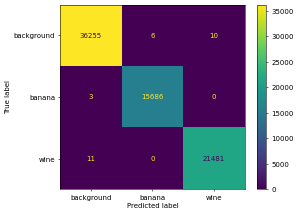

FOLD nº2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 0.9995779556717312
Precision:	 0.9995780527815082
Recall:		 0.9995779556717312
F1-score:	 0.9995779640005501


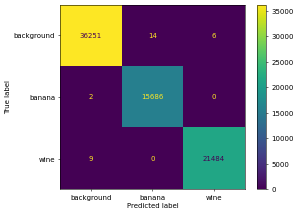

FOLD nº3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 0.9994826553395415
Precision:	 0.9994826961090864
Recall:		 0.9994826553395415
F1-score:	 0.9994826487153815


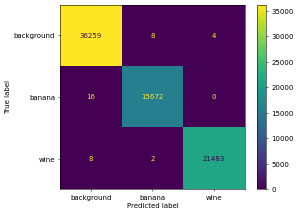

FOLD nº4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 0.9996187934813685
Precision:	 0.999618832207124
Recall:		 0.9996187934813685
F1-score:	 0.999618773043636


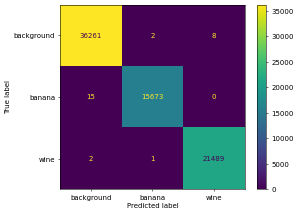

In [21]:
KFOLDS = 5
cv = StratifiedKFold(n_splits=KFOLDS, shuffle=True)

results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

X=df[FEATURES]
y=df['class']

for (train, test), i in zip(cv.split(X, y), range(KFOLDS)):
    print(f'FOLD nº{i}')
    X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy:\t",metrics.accuracy_score(y_test, y_pred))
    print("Precision:\t",metrics.precision_score(y_test, y_pred, average='weighted'))
    print("Recall:\t\t",metrics.recall_score(y_test, y_pred, average='weighted'))
    print("F1-score:\t",metrics.f1_score(y_test, y_pred, average='weighted'))
    plt.rcParams['figure.dpi'] = 50
    cm = metrics.confusion_matrix(y_test, y_pred)
    cmdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    cmdisp.plot()
    plt.show()

Probamos con una muestra creada de cero con datos de background

In [50]:
OLD_F_METADATA = "./data/HT_Sensor_metadata.dat"
F_METADATA = "./data/HT_Sensor_metadata_new.dat"
OLD_F_DATASET = "./data/HT_Sensor_dataset.dat"
F_DATASET = "./data/HT_Sensor_dataset_new.dat"
F_TEST_DATASET = "./data/filas_test.dat"

FEATURES_ORIGINAL = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
FEATURES = [
  'R1', 'R1_mean', 'R1_dev',
  'R2', 'R2_mean', 'R2_dev',
  'R3', 'R3_mean', 'R3_dev',
  'R4', 'R4_mean', 'R4_dev',
  'R5', 'R5_mean', 'R5_dev',
  'R6', 'R6_mean', 'R6_dev',
  'R7', 'R7_mean', 'R7_dev',
  'R8', 'R8_mean', 'R8_dev',
]

time_window = 5
md = pd.read_csv(F_METADATA, sep=",")
d = pd.read_csv(F_DATASET, sep=",")
d.set_index(np.arange(d.shape[0]), inplace=True)

with open(F_TEST_DATASET, 'w') as f:
    # Headers
    f.write(','.join(FEATURES) + '\n')

    """
    1. Por cada serie (misma ID) en HT_Sensor_dataset_new.dat
      2. Calcular media, mediana y desv. de cada sensor, temperatura y humedad en base a los ultimos 5 minutos
      3. Añadir la nueva entrada a Final_dataset.dat
    """
    for i, md_row in md.iterrows():
        ide = md_row['id']
        clase = md_row['class']
        print(f'{ide} {clase} .... ', end='')

        for j, d_row in d.iterrows():
            # Si no son la misma serie, pasamos al siguiente
            if md_row['id'] != d_row['id']: continue

            # Ignorar la ventana
            if d_row['time'] >= 0 and d_row['time'] <= md_row['dt']: continue

            search_to = d_row['time']*60            # Muestra actual a minutos
            search_from = search_to - time_window   # Ventana de 5 minutos desde la que empezar a buscar

            # Debe estar dentro de la ventana de tiempo y tener el mismo ID.
            window = d[(d['time']*60 >= search_from) & (d['time']*60 < search_to) & (d['id'] == md_row['id'])]
            if window.empty: continue

            for f_o in FEATURES_ORIGINAL:
                # 1. Calcular medias, medianas y desviaciones de los atributos del df 'window'
                mean = window[f_o].mean()
                median = window[f_o].median()
                dev = window[f_o].std(ddof=0)
                d_row[f'{f_o}_mean'] = mean
                d_row[f'{f_o}_median'] = median
                d_row[f'{f_o}_dev'] = dev

            # 2. Esos nuevos valores obtenidos, meterlos a la entrada 'd_row' y guardarla: f.write(new_row)
            x = d_row[2:].to_string(index=False).split('\n')
            new_row = [','.join(ele.split()) for ele in x]
            f.write(','.join(new_row) + '\n')
        print('OK')

0 banana .... OK
1 wine .... OK
2 wine .... OK
3 banana .... OK
4 wine .... OK
5 banana .... OK
6 wine .... OK
7 banana .... OK
8 wine .... OK
9 banana .... OK
10 banana .... OK
11 banana .... OK
12 wine .... OK
13 banana .... OK
14 wine .... OK
15 banana .... OK
16 banana .... OK
17 banana .... OK
18 banana .... OK
19 wine .... OK
20 wine .... OK
21 banana .... OK
22 banana .... OK
23 wine .... OK
24 wine .... OK
25 wine .... OK
26 wine .... OK
27 banana .... OK
28 wine .... OK
29 wine .... OK
30 banana .... OK
31 wine .... OK
32 wine .... OK
33 banana .... OK
34 banana .... OK
35 banana .... OK
36 wine .... OK
37 wine .... OK
38 wine .... OK
39 banana .... OK
40 banana .... OK
41 wine .... OK
42 wine .... OK
43 banana .... OK
44 wine .... OK
45 wine .... OK
46 wine .... OK
47 banana .... OK
48 banana .... OK
49 wine .... OK
50 wine .... OK
51 banana .... OK
52 banana .... OK
53 wine .... OK
54 wine .... OK
55 banana .... OK
56 wine .... OK
57 banana .... OK
58 wine .... OK
59 banana 

In [53]:
F_TEST_DATASET = "./data/filas_test.dat"
FEATURES = [
  'R1', 'R1_mean', 'R1_dev',
  'R2', 'R2_mean', 'R2_dev',
  'R3', 'R3_mean', 'R3_dev',
  'R4', 'R4_mean', 'R4_dev',
  'R5', 'R5_mean', 'R5_dev',
  'R6', 'R6_mean', 'R6_dev',
  'R7', 'R7_mean', 'R7_dev',
  'R8', 'R8_mean', 'R8_dev',
#   'Temp.', 'Temp._mean', 'Temp._dev',
#   'Humidity', 'Humidity_mean', 'Humidity_dev',
]

dtest = pd.read_csv(F_TEST_DATASET, sep=",")
dtest['class']  = 'background'
dtest.head()

,,,,,,,,,,,,,,,,R1,R1_mean,R1_dev,R2,R2_mean,R2_dev,R3,R3_mean,R3_dev,R4,...,R6,R6_mean,R6_dev,R7,R7_mean,R7_dev,R8,R8_mean,R8_dev,class
12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299,12.862100,12.8621,0.000000,10.368300,10.36830,0.000000,10.43830,10.43830,0.000000,11.669900,11.6699,0.000000,13.493100,13.49310,0.000000,13.342300,...,8.739010,8.739010,0.000000,26.22570,26.22570,0.000000,59.052800,59.05280,0.000000,background
12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093,12.861900,12.8619,0.000200,10.368250,10.36825,0.000050,10.43790,10.43790,0.000400,11.669800,11.6698,0.000100,13.492900,13.49290,0.000200,13.341750,...,8.739045,8.739045,0.000035,26.22825,26.22825,0.002550,59.041350,59.04135,0.011450,background
12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905,12.861500,12.8617,0.000589,10.368367,10.36830,0.000170,10.43760,10.43750,0.000535,11.669733,11.6697,0.000125,13.492733,13.49270,0.000287,13.341333,...,8.739080,8.739080,0.000057,26.23100,26.23080,0.004411,59.030667,59.02990,0.017767,background
12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736,12.861175,12.8612,0.000760,10.368425,10.36845,0.000179,10.43745,10.43725,0.000532,11.669725,11.6697,0.000109,13.492575,13.49255,0.000370,13.340950,...,8.739150,8.739115,0.000131,26.23365,26.23365,0.005972,59.020625,59.01960,0.023222,background
12.8594,10.3691,10.4376,11.6702,13.4921,13.3382,8.04088,8.74016,26.2503,58.9583,12.860840,12.8607,0.000954,10.368500,10.36860,0.000219,10.43744,10.43740,0.000476,11.669760,11.6697,0.000120,13.492440,13.49240,0.000427,13.340560,...,8.739292,8.739150,0.000307,26.23616,26.23650,0.007330,59.011220,59.00930,0.028022,background


In [54]:
dtest.shape

(675168, 25)

(675168,) (675168, 24)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Accuracy: 0.8236290819470117
Precision: 1.0
F1-score: 0.9032857504856828


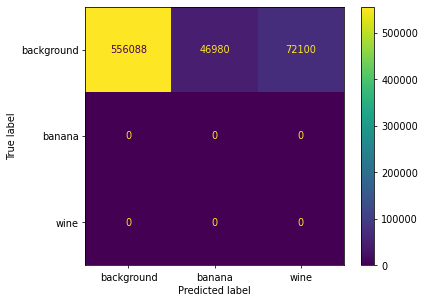

In [55]:
y_test=dtest['class']
X_test = dtest[FEATURES]
print(y_test.shape, X_test.shape)
y_pred = clf.predict(X_test)

print_metrics(y_test, y_pred)

Ahora haremos hyperparameter tuning para comprobar los mejores valores:

* max_samples: Un decimal entre 0 y 1 que representa el % sobre el nº total de muestras sobre el que se crean los datasets bootstrap para entrenar los arboles. Un valor de 0.5 en un dataset de 100 muestras significa que cada arbol se entrena con un conjunto boostrap de 0.5·100 = 50 muestras

* max_features: nº de atributos que se seleccionan aleatoriamente de cada punto de corte. Por defecto es la raiz cuadrada del numero de atributos (sqrt(24)~4 en nuestro caso). Comprobar valores entre 1 y 8 para ver si sqrt(24) es el mejor o no.

* n_estimators: Numero de arboles en el bosque. Inicialmente lo ponemos a 10 y va bien. Mirar con valores < y > que 10. Por ej: 3, 5, 7, 10, 20, 30, 50, 100. Se supone que a partir del valor optimo el accuracy deberia aplanarse.